# 항적 데이터에서 선형 보간법으로결측치 대체 
## Y722항로는 제주와 김포공항을 이어주는 항로이며, 자료는 이 곳을 지나는 항적 자료이다. 
## 각 항적마다 수신된 시간과 구간이 다르며 미 수신구간이 존재하기도 한다.


In [56]:
library(ggplot2)
library(ggmap)
library(GISTools)
library(imputeTS)
library(lubridate)
library(ggmap)
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:lubridate':

    intersect, setdiff, union

The following objects are masked from 'package:rgeos':

    intersect, setdiff, union

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



## 각 day_call 기준으로 총 169개의 항적이 존재하고, 수신된 시간마다의 정보가 존재한다

In [50]:
data=read.csv('C:/Users/admin/Desktop/졸업논문/data/y722_2.csv',stringsAsFactors = F)
head(data)

Time,id,CallSign,lat,lon,Alt.fit,day,day_call,landing,airport,departure,land
2017-07-01 9:43:00,71BD061,AAR8954,36.12415,126.9745,26650,2017-07-01,2017-07-01 71BD061 AAR8954,landing,gimpo,CJU,GMP
2017-07-01 9:43:00,71BD061,AAR8954,36.14314,126.9767,26275,2017-07-01,2017-07-01 71BD061 AAR8954,landing,gimpo,CJU,GMP
2017-07-01 9:44:00,71BD061,AAR8954,36.18841,126.9816,25325,2017-07-01,2017-07-01 71BD061 AAR8954,landing,gimpo,CJU,GMP
2017-07-01 9:44:00,71BD061,AAR8954,36.25731,126.9892,24550,2017-07-01,2017-07-01 71BD061 AAR8954,landing,gimpo,CJU,GMP
2017-07-01 9:09:00,71BD58_0,JNA306,36.09810,126.9716,27225,2017-07-01,2017-07-01 71BD58_0 JNA306,landing,unknown,CJU,GMP
2017-07-01 9:10:00,71BD58_0,JNA306,36.17075,126.9795,26625,2017-07-01,2017-07-01 71BD58_0 JNA306,landing,unknown,CJU,GMP


In [51]:
data_list=split(data,data$day_call)
length(data_list)

[1] 169

## 하지만 yy:mm:ss에서 중복된 시간이 존재하고, 오랜 시간 미수신된 구간이 존재한다.
## Y722항로는 짧은 직선 구간의 항로로 선형성이 유지되는 구간으로, 선형 보간법을 통해 미 수신구간을 해결하고자 한다. 1) 시간정보를 포함한 자료와 2) 시간정보를 포함하지 않은 자료 두가지 기준으로 진행하려고 한다.

In [53]:
data_list[[3]]
data_list[[30]]

,Time,id,CallSign,lat,lon,Alt.fit,day,day_call,landing,airport,departure,land
8,2017-07-01 18:04:00,71BD603,KAL1246,36.09984,126.9716,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
9,2017-07-01 18:05:00,71BD603,KAL1246,36.19514,126.9824,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
10,2017-07-01 18:05:00,71BD603,KAL1246,36.20819,126.9839,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
11,2017-07-01 18:05:00,71BD603,KAL1246,36.21007,126.9842,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
12,2017-07-01 18:05:00,71BD603,KAL1246,36.29420,126.9935,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
13,2017-07-01 18:06:00,71BD603,KAL1246,36.31206,126.9955,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
14,2017-07-01 18:06:00,71BD603,KAL1246,36.33253,126.9977,25000,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
15,2017-07-01 18:06:00,71BD603,KAL1246,36.35225,126.9999,24975,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP
16,2017-07-01 18:06:00,71BD603,KAL1246,36.36303,127.0011,24900,2017-07-01,2017-07-01 71BD603 KAL1246,landing,unknown,CJU,GMP


,Time,id,CallSign,lat,lon,Alt.fit,day,day_call,landing,airport,departure,land
225,2017-07-06 22:05:30,71BF252,KAL1264,36.12687,126.9747,25000,2017-07-06,2017/07/06 71BF252 KAL1264,landing,gimpo,CJU,GMP
226,2017-07-06 22:05:40,71BF252,KAL1264,36.17844,126.9804,25000,2017-07-06,2017/07/06 71BF252 KAL1264,landing,gimpo,CJU,GMP
227,2017-07-06 22:05:50,71BF252,KAL1264,36.20256,126.9831,25000,2017-07-06,2017/07/06 71BF252 KAL1264,landing,gimpo,CJU,GMP
228,2017-07-06 22:06:15,71BF252,KAL1264,36.24966,126.9883,25000,2017-07-06,2017/07/06 71BF252 KAL1264,landing,gimpo,CJU,GMP
229,2017-07-06 22:06:18,71BF252,KAL1264,36.25717,126.9892,25000,2017-07-06,2017/07/06 71BF252 KAL1264,landing,gimpo,CJU,GMP
230,2017-07-06 22:06:19,71BF252,KAL1264,36.26005,126.9895,25000,2017-07-06,2017/07/06 71BF252 KAL1264,landing,gimpo,CJU,GMP


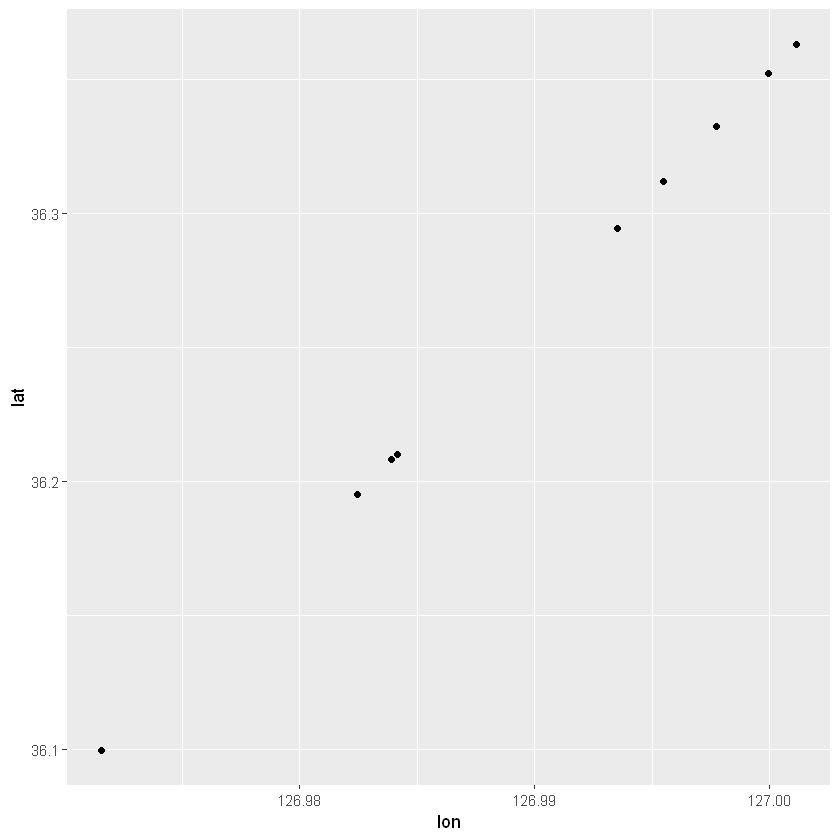

In [26]:
ggplot(data_list[[3]])+geom_point(aes(x=lon,y=lat))

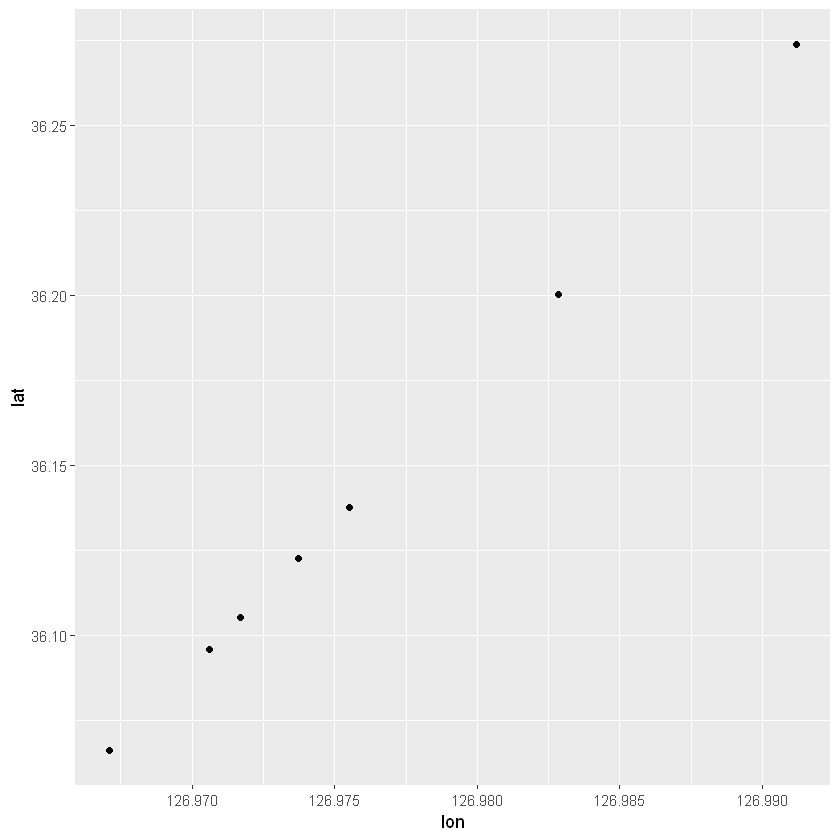

In [54]:
ggplot(data_list[[16]])+geom_point(aes(x=lon,y=lat))

# 1) 시간 정보를 포함한 자료
## 각 항적의 수신된 첫번째 시간과 마지막 시간 사이에 시간을 생성하여 관측되지 않은 시간에 대해서 선형 보간법으로 결측치를 대체한다. 각 항적의 수신된 구간과 길이가 다를 수 밖에 없다

In [62]:
##data_list[[i]], for문을 사용하여 169개의 항적에 대해 진행할 수 있음.

time_dat<-data_list[[3]][,c(1,4,5)]
ind<-duplicated(time_dat$Time)
time_dat2<-time_dat[ind==F,]

Time_fst=time_dat$Time[1]
Time_last=time_dat$Time[length(time_dat$Time)]



date<-seq(ymd_hms(Time_fst),ymd_hms(Time_last),1)
date1<-data.frame(substr(date,1,19))
names(date1)<-"Time"



missing_dat<-left_join(date1,time_dat2,by=c("Time"="Time"))

missing_dat$lat<-na_interpolation(missing_dat$lat,option = "linear")
missing_dat$lon<-na_interpolation(missing_dat$lon,option = "linear")

missing_dat


Time,lat,lon
2017-07-01 18:04:00,36.09984,126.9716
2017-07-01 18:04:01,36.10143,126.9718
2017-07-01 18:04:02,36.10302,126.9719
2017-07-01 18:04:03,36.10460,126.9721
2017-07-01 18:04:04,36.10619,126.9723
2017-07-01 18:04:05,36.10778,126.9725
2017-07-01 18:04:06,36.10937,126.9727
2017-07-01 18:04:07,36.11096,126.9728
2017-07-01 18:04:08,36.11255,126.9730
2017-07-01 18:04:09,36.11413,126.9732


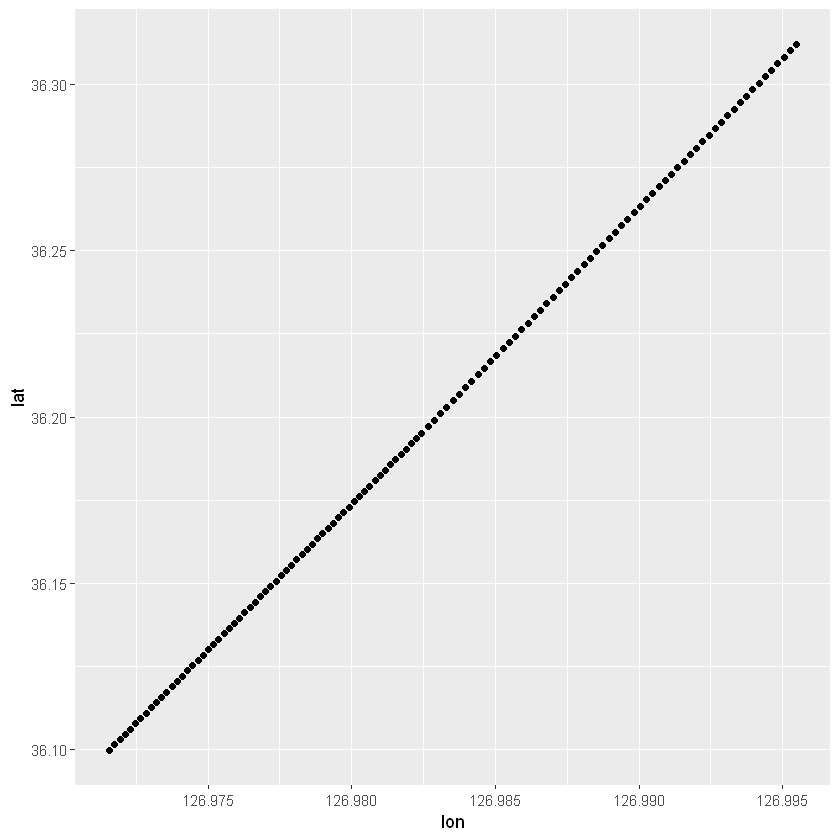

In [59]:

ggplot(missing_dat)+geom_point(aes(x=lon,y=lat))


# 2) 시간 정보를 포함하지 않은 자료
## 시간에 대한 정보는 생각하지 않고, 특정 구간에서의 각 항적을 선형 보간법으로 결측치를 대체한다. 이 경우, 각 항적의 수신된 구간과 길이가 같아지기 때문에 추후 분석에 용이할 수 있다.

In [60]:
## 역시 for문으로 한번에 진행할 수 있다.
## Y722항로의 위도 35.9 ~ 36.38 사이에서, 위도를 0.01간격으로 고정시켜 경도에 대해 결측치 대체를 진행할 수 있다.

y<-seq(35.9,36.38,by=0.01)


name<-data_list[[3]]$day_call[1]
first.lat<-data_list[[3]]$lat[1]
last.lat<-data_list[[3]]$lat[length(data_list[[3]]$lon)]
first.lon<-data_list[[3]]$lon[1]
last.lon<-data_list[[3]]$lon[length(data_list[[3]]$lon)]


slope<-(last.lat-first.lat)/(last.lon-first.lon)
intercept<-slope*(-first.lon)+first.lat

dat<-cbind.data.frame(name,slope,intercept)
x<-(y-intercept)/slope
intpol<-cbind.data.frame(name,y,x)
names(intpol)<-c("name","lat","lon")

intpol


name,lat,lon
2017-07-01 71BD603 KAL1246,35.90,126.9491
2017-07-01 71BD603 KAL1246,35.91,126.9502
2017-07-01 71BD603 KAL1246,35.92,126.9514
2017-07-01 71BD603 KAL1246,35.93,126.9525
2017-07-01 71BD603 KAL1246,35.94,126.9536
2017-07-01 71BD603 KAL1246,35.95,126.9547
2017-07-01 71BD603 KAL1246,35.96,126.9559
2017-07-01 71BD603 KAL1246,35.97,126.9570
2017-07-01 71BD603 KAL1246,35.98,126.9581
2017-07-01 71BD603 KAL1246,35.99,126.9592


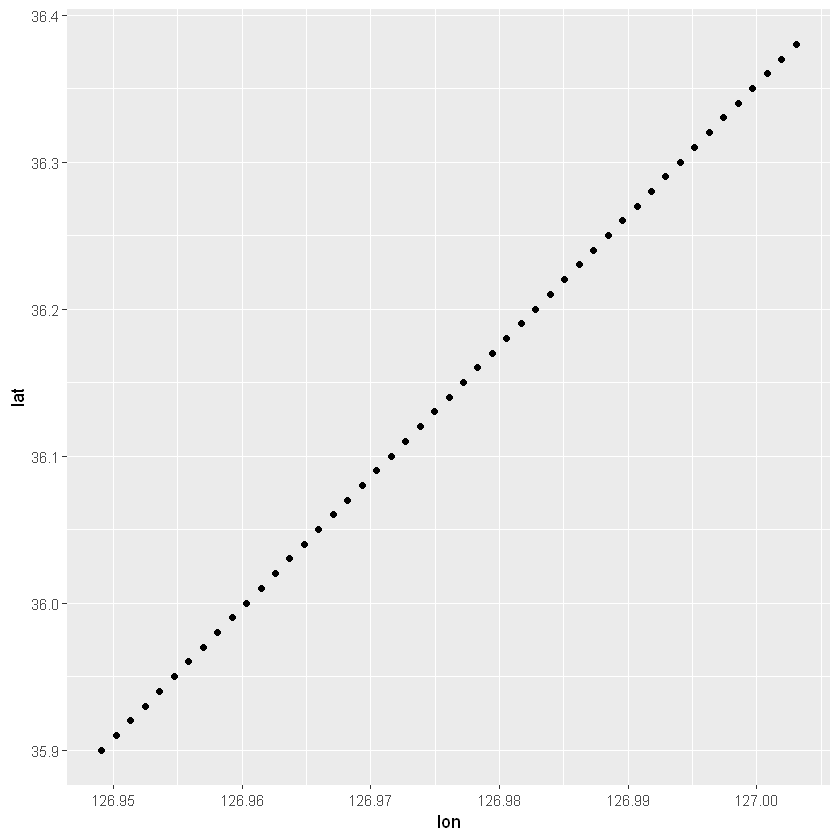

In [61]:

ggplot(intpol)+geom_point(aes(x=lon,y=lat))
    
